## Analysing the Metadata of an Organization (a Publisher) - Ordnance Survey Ireland:

#### This shows how to extract information about datasets/publishers (CKAN refers to publishers internally as organizations):

This gives an overview of how to analyse the data that belongs to the particular organization. The find organization function helps to find_organization_id you are looking for and organization_show helps to extract all the packages/datasets id that belongs to the organization (only 1000 ids can be extracted once). In addition to packages ids, these function also returns the meta information of the organization and the datasets.

This shows how to do a analysis on the available meta information about the publishers/organizations. Here for the demo purpose Ordance Survey Ireland is taken as an example for organization, however we can do analysis on meta information vailable on any organization.

##### Import all requirements

In [1]:
!pip install requests fuzzywuzzy pandas pyjstat numpy plotly matplotlib seaborn wordcloud

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


##### Import all necessary libraries:

In [2]:
import requests
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import sys
import pandas as pd
from pyjstat import pyjstat
import numpy as np
from pyjstat import pyjstat
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from IPython.display import display, HTML
import plotly.tools as tls
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.image as mpimg

### Find organization id by fuzzy matching search term: Ordance Survey Ireland

This helps users to fetch the organization id given name of the organization. For example, for given name Ordancd Survey Ireland, this functions fetches the id of the corresponding organization - 

In [3]:
def find_organization_id(url, org_name, param):
    
    try:

        response = requests.get(url, param)
        results = response.json()

        if not results['success']:
            raise SystemError

        if len(results['result']) == 0:

            return ("No matching Organization found")

        else:

            ratio = {}

            for index, x in enumerate(results['result']):
                ratio[index] = fuzz.ratio(org_name, x['display_name'])

            mtch_rtr = sorted(ratio.values())[-1]

            if mtch_rtr >= 75:

                lKey = [k for k,v in ratio.items() if v == mtch_rtr]

                return results['result'][int(lKey[0])]

            else:
                return ("No matching Organization found")

    except SystemError:
        print("Failure in request - bad action/url")
        sys.exit(1)
        
    except Exception as e:
        print(e)
        sys.exit(1)
        

#### Meta Information for the Organization Ordnance Survey Ireland:
This function fetches the datasets id and corresponding meta information like, url, star rating, tags, name, number of resources, formats available and its corresponding analysis.

In [4]:
def find_all_datasets_for_org(url, org_name):
    
    try: 
        
        param_find_org = {'all_fields': True}
        
        org_id = find_organization_id(url+'api/3/action/organization_list', org_name, param_find_org)['id']
        
        param_pkgs = {'id': org_id, 'include_users': True, 'include_dataset_count': True, 
                      'include_users': True, 'include_groups': True, 'include_tags': True, 'include_datasets': True}
        
        response = requests.get(url+'api/3/action/organization_show', param_pkgs)
        results_org = response.json()
        
        if not results_org['success']:
            raise SystemError

        if len(results_org['result']) == 0:
            raise Exception
            
        pkg_cnt = results_org['result']['package_count']
        frmts_cnt = {}
        star_cnt = {}
        tags_cnt = {}
        
        df_ids_details = []
        
        for x in results_org['result']['packages']:
            
            
            param_pkg_show = {'id': x['id']}
            response = requests.get(url+'api/3/action/package_show', param_pkg_show)
            results_pkg = response.json()
            
            if results_pkg['result']['qa']['openness_score'] in list(star_cnt.keys()):
                    
                star_cnt[results_pkg['result']['qa']['openness_score']] += 1
                    
            else:
                    
                star_cnt[results_pkg['result']['qa']['openness_score']] = 1
                    
            
            
            frmt = []
            tag_nm = []
            
            for tag in results_pkg['result']['tags']:
                
                tag_nm.append(tag['display_name'].strip())
                    
                if tag['display_name'].strip() in list(tags_cnt.keys()):
                    
                    tags_cnt[tag['display_name'].strip()] += 1
                    
                else:
                    
                    tags_cnt[tag['display_name'].strip()] = 1
        
            
            for y in results_pkg['result']['resources']:
                
                frmt.append(y['format'])
                
                if y['format'] in list(frmts_cnt.keys()):
                    
                    frmts_cnt[y['format']] += 1
                    
                else:
                    
                    frmts_cnt[y['format']] = 1
                    
            
            df_ids_details.append({'id': x['id'], 'num_tags':x['num_tags'], 'num_resources':x['num_resources'],
                                  'name': x['name'], 'url':x['url'], 'formats': ", ".join(frmt), 
                                  'star_rating': results_pkg['result']['qa']['openness_score'],
                                  'tags': ", ".join(tag_nm)})
            
        
            
        return pd.DataFrame(sorted(df_ids_details, key=lambda k: k['star_rating'], reverse=True)), frmts_cnt, star_cnt, tags_cnt
        
        
    except SystemError:
        print("Failure in request - bad organization name"\
              "Hint: No matching organization found - please check the name of the organization")
        sys.exit(1)
        
    except Exception as e:
        
        print(e)
        sys.exit(1)
        

        
hg_score_df, frmts_cnt, star_cnt, tags_cnt = find_all_datasets_for_org('https://data.gov.ie/', 'Ordancd Survey Ireland')

### Metadata of the publisher: Ordnance Survey Ireland

In [5]:
display(HTML(hg_score_df.head().to_html()))

,formats,id,name,num_resources,num_tags,star_rating,tags,url
0,"ttl, rdf-xml",bf293fc8-cfe5-42a0-a31b-f47b75285f6d,osi-national-statutory-boundary-linked-data,2,8,5,"adapt, boundary, geospatial, linked data, osi,...",http://data.geohive.ie/
1,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",3054fb53-b1b4-4148-b2ac-11c99524327d,baronies-osi-national-placenames-gazetteer,6,5,3,"Baronies, OSi National Placenames Gazetteer, O...",http://data-osi.opendata.arcgis.com/datasets/2...
2,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",5029a660-de34-41ed-9484-6526d5794a34,centres-of-population-osi-national-placenames-...,6,5,3,"Centres of Population, OSi National Placenames...",http://data-osi.opendata.arcgis.com/datasets/a...
3,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",aa7fe29c-d353-427f-9d88-d8e29699a101,civil-parishes-osi-national-placenames-gazetteer,6,5,3,"Civil Parishes, OSi National Placenames Gazett...",http://data-osi.opendata.arcgis.com/datasets/d...
4,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",c5385677-c7ea-4c1e-bd73-eb7b265250b2,counties-osi-national-placenames-gazetteer,6,6,3,"Admin, Counties, OSi National Placenames Gazet...",http://data-osi.opendata.arcgis.com/datasets/8...


In [6]:
pd.DataFrame({"Formats": list(frmts_cnt.keys()), 'Count': list(frmts_cnt.values())}).head()

,Formats,Count
0,HTML,154
1,Esri REST,154
2,GeoJSON,154
3,CSV,154
4,KML,154


In [7]:
print(star_cnt)
star_cnt[1] = 0
star_cnt[2] = 0
star_cnt[4] = 0
star_cnt = dict(collections.OrderedDict(sorted(star_cnt.items())))
print(star_cnt)

{3: 154, 5: 1}
{1: 0, 2: 0, 3: 154, 4: 0, 5: 1}


In [8]:
pd.DataFrame({"Tags": list(tags_cnt.keys()), 'Count': list(tags_cnt.values())}).head()

,Tags,Count
0,Baronies,1
1,OSi National Placenames Gazetteer,7
2,OpenData,48
3,administrative,16
4,placenames,8


### Extracting Top 5 Datasets of Ordnance Survey Ireland:

This selection is based on the star rating of the resources:

In [9]:
hg_score_df.to_csv('Top05_org_OSI.csv')
hg_score_df.head()

,formats,id,name,num_resources,num_tags,star_rating,tags,url
0,"ttl, rdf-xml",bf293fc8-cfe5-42a0-a31b-f47b75285f6d,osi-national-statutory-boundary-linked-data,2,8,5,"adapt, boundary, geospatial, linked data, osi,...",http://data.geohive.ie/
1,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",3054fb53-b1b4-4148-b2ac-11c99524327d,baronies-osi-national-placenames-gazetteer,6,5,3,"Baronies, OSi National Placenames Gazetteer, O...",http://data-osi.opendata.arcgis.com/datasets/2...
2,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",5029a660-de34-41ed-9484-6526d5794a34,centres-of-population-osi-national-placenames-...,6,5,3,"Centres of Population, OSi National Placenames...",http://data-osi.opendata.arcgis.com/datasets/a...
3,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",aa7fe29c-d353-427f-9d88-d8e29699a101,civil-parishes-osi-national-placenames-gazetteer,6,5,3,"Civil Parishes, OSi National Placenames Gazett...",http://data-osi.opendata.arcgis.com/datasets/d...
4,"HTML, Esri REST, GeoJSON, CSV, KML, ZIP",c5385677-c7ea-4c1e-bd73-eb7b265250b2,counties-osi-national-placenames-gazetteer,6,6,3,"Admin, Counties, OSi National Placenames Gazet...",http://data-osi.opendata.arcgis.com/datasets/8...


### Visualising the metadata

#### Viz 1: Star Rating and its count - Ordnance Survey Ireland:

In [10]:
""" Please note, ploty dosent show image in colab hence using static image. 
However, you can also use ploty object in imshow() in your local machine"""

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as po

init_notebook_mode(connected=True)

y_saving = list(np.asarray(list(star_cnt.values()))/sum(star_cnt.values()))
y_net_worth = list(star_cnt.values())
                
x_saving = ['1-star', '2-star', '3-star', '4-star', '5-star']
x_net_worth = ['1-star', '2-star', '3-star', '4-star', '5-star']

trace0 = go.Bar(
    x=y_saving,
    y=x_saving,
    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Percentage of packages/datasets in a given star rating',
    orientation='h',
)
trace1 = go.Scatter(
    x=y_net_worth,
    y=x_net_worth,
    mode='lines+markers',
    line=dict(
        color='rgb(128, 0, 128)'),
    name='Number of resources in a given star rating',
)
layout = dict(
    title='Analysis of Star Rating vs Datasets for the publisher Ordnance Survey Ireland',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        domain=[0, 0.85],
    ),
    yaxis2=dict(
        showgrid=False,
        showline=True,
        showticklabels=False,
        linecolor='rgba(102, 102, 102, 0.8)',
        linewidth=2,
        domain=[0, 0.85],
    ),
    xaxis=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0, 0.42],
    ),
    xaxis2=dict(
        zeroline=False,
        showline=False,
        showticklabels=True,
        showgrid=True,
        domain=[0.47, 1],
        side='top',
        dtick=25000,
    ),
    legend=dict(
        x=0.029,
        y=1.038,
        font=dict(
            size=10,
        ),
    ),
    margin=dict(
        l=100,
        r=20,
        t=70,
        b=70,
    ),
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

annotations = []

y_s = np.round(y_saving, decimals=2)
y_nw = np.rint(y_net_worth)

# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_saving):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ydn - 20000,
                            text='Count: '+'{:,}'.format(ydn),
                            font=dict(family='Arial', size=12,
                                      color='rgb(128, 0, 128)'),
                            showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=yd + 3,
                            text=str(yd) + '%',
                            font=dict(family='Arial', size=12,
                                      color='rgb(50, 171, 96)'),
                            showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper',
                        x=-0.2, y=-0.109,
                        text='Star Rating Analysis of Ordnance Survey Ireland',
                        font=dict(family='Arial', size=10,
                                  color='rgb(150,150,150)'),
                        showarrow=False))

layout['annotations'] = annotations

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)
#iplot(fig, filename='oecd-networth-saving-bar-line')
Image(url= "https://github.com/derilinx/Developer_Corner_DGI/blob/master/star_rating.png?raw=true", width=900, height=500)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



#### Viz 2 - Available data formats in Ordnance Survey Ireland:

In [11]:
""" Please note, ploty dosent show image in colab hence using static image. 
However, you can also use ploty object in imshow() in your local machine"""

frmt_df = pd.DataFrame({'Dataset Format': list(frmts_cnt.keys()), 'Count': list(frmts_cnt.values())})
frmt_df_cpy = frmt_df.copy()
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Scatterpolar(
      r = list(np.asarray(list(frmts_cnt.values()))/sum(list(frmts_cnt.values()))),
      theta = list(frmts_cnt.keys()),
      fill = 'toself',
      name = 'Datasets formats and its counts'
    )
]

layout = go.Layout(
    title = "Available Data Formats (%) in Ordnance Survey Ireland",
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 0.5]
    )
  ),
  showlegend = True
)

fig1 = go.Figure(data=data, layout=layout)
#iplot(fig1, filename = 'radar', image='png')
#plotly.offline.plot(fig1, filename='radar', image='png')
Image(url= "https://github.com/derilinx/Developer_Corner_DGI/blob/master/radar_format.png?raw=true", width=900, height=500)

#### Vis 3 - Percentage of data fromats

In [12]:
""" Please note, ploty dosent show image in colab hence using static image. 
However, you can also use ploty object in imshow() in your local machine"""

import plotly.plotly as py
import plotly.graph_objs as go

fig2 = {
  "data": [
    {
      "values": list(np.asarray(list(dict(frmt_df_cpy.groupby('Dataset Format')['Count'].agg('sum')).values()))/sum(list(dict(frmt_df_cpy.groupby('Dataset Format')['Count'].agg('sum')).values()))),
      "labels": list(dict(frmt_df_cpy.groupby('Dataset Format')['Count'].agg('sum')).keys()),
      "name": '% of count',
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Distribution of datsets formats",
        "annotations": [
            {
                "font": {
                    "size": 11
                },
                "showarrow": False,
                "text": "Formats",
                "x": 0.16,
                "y": 0.5
            }
        ]
    }
}

#iplot(fig2, filename='donut', image='png')
Image(url= "https://github.com/derilinx/Developer_Corner_DGI/blob/master/pie_format.png?raw=true", width=900, height=500)

#### Viz 4 (word cloud) - Most frequent Tags in Ordance Survey Ireland:

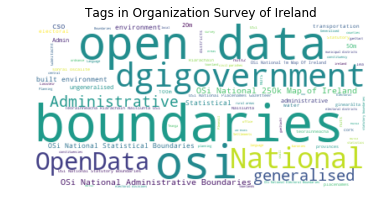

In [13]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

wc = WordCloud(background_color="white", max_words=200, relative_scaling=0.5, normalize_plurals=False).generate_from_frequencies(tags_cnt)

plt.figure()
plt.title("Tags in Organization Survey of Ireland")
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('tag_wordcloud', dpi=500)
plt.show()

### Viz 4: Top 40 tags in Ordnance Survey Ireland

In [15]:
""" Please note, ploty dosent show image in colab hence using static image. 
However, you can also use ploty object in imshow() in your local machine"""

import plotly.plotly as py
import plotly.graph_objs as go

tags_cnt_ordr = dict(sorted(tags_cnt.items(), key=lambda x: x[1], reverse=True))

data = [go.Bar(
            x=list(tags_cnt_ordr.keys())[:40],
            y=list(tags_cnt_ordr.values())[:40],
            name = "Count: "
    )]


layout = go.Layout(
    title='Top 40 tags in organization - Ordance Survey Ireland',
    xaxis=dict(
        title='Tag Words',
        tickangle=-45,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Tag Count',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig3 = go.Figure(data=data, layout=layout)
Image(url= "https://github.com/derilinx/Developer_Corner_DGI/blob/master/tag_bar.png?raw=true", width=900, height=500)
#iplot(fig3, filename='horizontal-bar', image='png')

## Publisher dashboard: Ordnance Survey Ireland

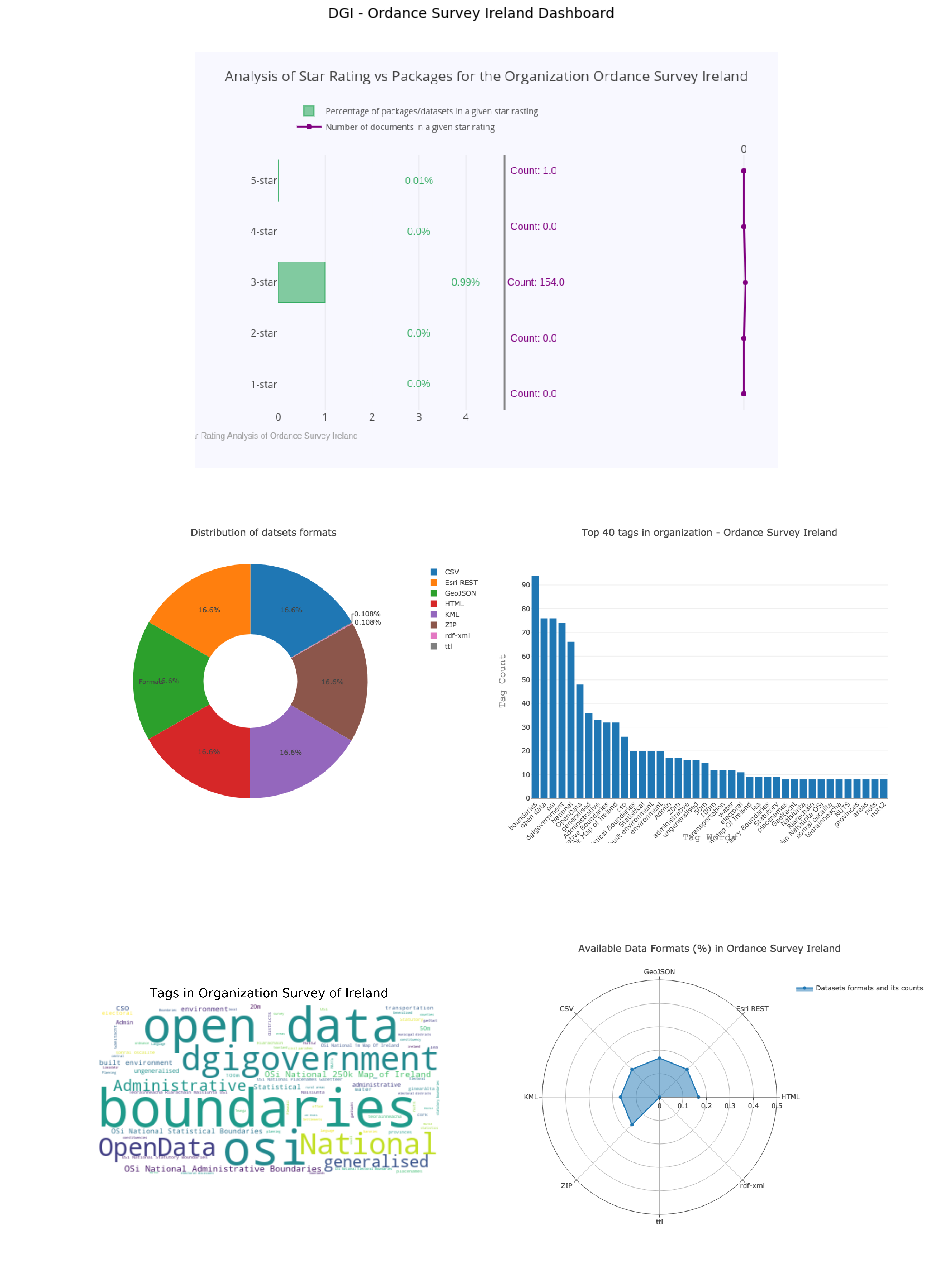

In [8]:
""" Please note, ploty dosent show image in colab hence using static image. 
However, you can also use ploty object in imshow() in your local machine"""

import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams['figure.figsize'] = 16 ,21

# Create 2x2 sub plots
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0, hspace=0)

pl.figure()
ax = pl.subplot(gs[0, :])
ax.axis('off')
pl.imshow(mpimg.imread("https://github.com/derilinx/Developer_Corner_DGI/blob/master/star_rating.png?raw=true"))

ax = pl.subplot(gs[1, 0]) 
ax.axis('off')
pl.imshow(mpimg.imread("https://github.com/derilinx/Developer_Corner_DGI/blob/master/pie_format.png?raw=true"))

ax = pl.subplot(gs[1, 1])
ax.axis('off')
pl.imshow(mpimg.imread("https://github.com/derilinx/Developer_Corner_DGI/blob/master/tag_bar.png?raw=true"))

ax = pl.subplot(gs[2, 0])
ax.axis('off')
pl.imshow(mpimg.imread("https://github.com/derilinx/Developer_Corner_DGI/blob/master/tag_wordcloud.png?raw=true"))

ax = pl.subplot(gs[2, 1])
ax.axis('off')
pl.imshow(mpimg.imread("https://github.com/derilinx/Developer_Corner_DGI/blob/master/radar_format.png?raw=true"))
pl.suptitle("DGI - Ordance Survey Ireland Dashboard", fontsize=14, fontweight=1)
pl.subplots_adjust(top=0.95)
pl.savefig('dashboard_dgi', dpi=500)